# Prepare and export stream files with `f3ast`

This notebook aims to give an overview of possible functionalities of the `f3ast` package, with probably only parts of it relevant to your specific structure/problem. Mix and match to your heart's delight :-)


## Import packages and define microscope settings


In [1]:
import sys
from numba import threading_layer
import numba
sys.path.append(r"C:/Users/bgh19/OneDrive/Coding/GithubRepos/f3ast")
import f3ast
import numpy as np
print(numba.set_num_threads(8))
print(numba.get_num_threads())

None
8


In [2]:
# settings can be loaded from a specified json file (given by file_path="...")
settings = f3ast.load_settings()

# or settings can be defined manually in a dictionary:
settings = {}
settings["structure"] = {"pitch": 3, "fill": False}  # in nm
settings["stream_builder"] = {
    "addressable_pixels": [65536, 56576],
    "max_dwt": 5,  # in ms
    "cutoff_time": 0.01,  # in ms, for faster exporting: remove dwells below cutoff time
    "screen_width": 10.2e3,  # in nm, horizontal screen width / field of view
    # 'serpentine' or 'serial', scanning order between slices
    "scanning_order": "serpentine",
}
# pixel size for thermal resistance
settings["dd_model"] = {"single_pixel_width": 50}

## Import and modify `stl` structure


In [32]:
file_path = "6x6CylinderArray-2.stl"
struct = f3ast.Structure.from_file(file_path, **settings["structure"])

# rotate: specify axis and angle in degrees
# this is for example useful if FEBID growth is done with a tilted SEM sample stage
rotation_axis, rotation_angle = (0, 0, 1), 0
struct.rotate(rotation_axis, rotation_angle)

# In some cases (e.g. Helios 600) , stream files appear mirrored on the SEM screen
# compared to the orientation of the initial stl structure.
# If precise orientation of the structure (e.g. with respect to the GIS) is important,
# a mirror operation can be applied across a plane with a given normal.
struct.mirror(normal=(1, 0, 0))

struct.centre()  # centers xy to zero and sets minimum z value to zero
struct.rescale(20)  # scale the structure 3x

# interactive plot for inspection
struct.show()

## Define the growth model

For the two main growth models - RRL (reaction-rate limited growth) with constant dwell time in height, and DD (desorption-dominated growth), for which the dwell time are modified taking into account increasing thermal resistance with structure length and height.


In [33]:
GR0 = 250e-3 # in um/s, base growth rate
k = 1.25 # in 1/nm?, thermal conductivity 
sigma = 4.4 # in nm, dwell size

# simple model, without thermal correction
# %time model = f3ast.RRLModel(struct, GR0, sigma)

# with correction due to thermal conductivity
%time model = f3ast.DDModel(struct, GR0, k, sigma, **settings['dd_model'])

print(threading_layer())


Slicing...
Sliced
CPU times: total: 40.6 s
Wall time: 36 s
omp


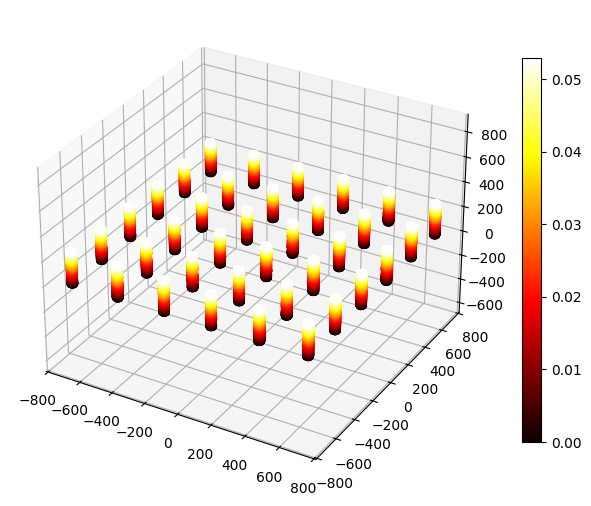

In [34]:
# plot thermal resistance for a check
# if there are discontinuities a z-dependent model for the dwell time might be better (see below)
ax, sc = struct.plot_slices(c=np.concatenate(model.resistance), cmap="hot")

## Solve for dwells and inspect


Solving for dwells...
Solved
CPU times: total: 625 ms
Wall time: 21 s
Total stream time:  0:03:42.824042


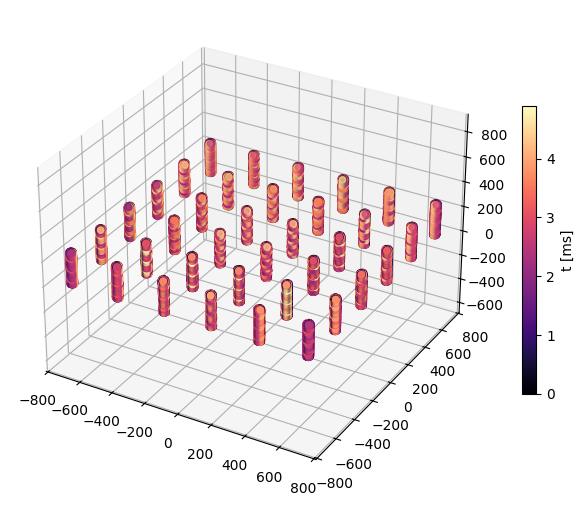

In [35]:
%time stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])
dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()

## Export stream files

Depending on the interface of the SEM/dual beam you are working with, the visible name of the stream file might be very short (e.g., 18 characters only for the Helios 600). In this case, it makes sense to keep a short filename, and/or put the most important pieces of information of the pattern into the beginning.

It can be helpful to also add the total writing time for an exported stream at the end, see example below how to create a descriptive filename from patterning parameters.


In [36]:
# get stream
strm = stream_builder.get_stream()

# export with simple name
out_filename = "6x6SquareArray-2"

# this is an example on how to build a descriptive filename
# e.g. with growth rate GR0 in nm/s, and total writing time in seconds
total_time = f"{strm.get_time().seconds}.{strm.get_time().microseconds/1e5:.0f}s"
out_filename = f"{out_filename}-GR{GR0*1e3:.0f}-{total_time}"
strm.write(f"{out_filename}.str")


In [8]:
# the stream can be loaded back if the stream_builder object is still defined:
# strm.from_file(f'{save_path}.str')

## Save models

`f3ast` also allows to save a stream builder object for later use. This is particularly useful for large structures to be treated with the DDModel, as the calculation of thermal correction/connectivity scales non-linearly with the size of the bounding box of the structure.


In [9]:
# save
save_path = "stream_test"
f3ast.save_build(save_path, dwell_solver, stream_builder)

# retrieve
load_path = f"{save_path}.pickle"
dwell_solver, stream_builder = f3ast.load_build(load_path)

## Exponential dwell time correction in $z$

Sometimes the DDModel does not work well, e.g., if the stl structure has disconnected segments -- in this case the above plot of the thermal resistance would feature discontinuities in $z$. For this case, the following model, based on doubling of the dwell time with height, can give better growth results.

The correct doubling length needs to be determined experimentally, e.g., by tracking how the pitch of a nominally periodic structure varies with growth height.


Solving for dwells...
Solved
CPU times: user 250 ms, sys: 17.8 ms, total: 267 ms
Wall time: 1.74 s
Total stream time:  0:01:50.044051


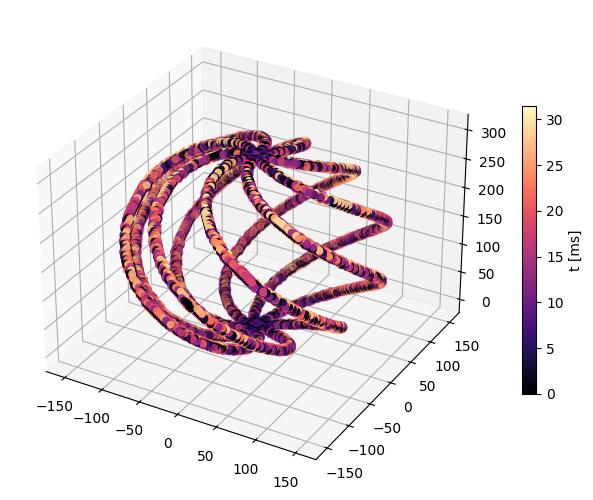

In [10]:
from f3ast.deposit_model import HeightCorrectionModel

# settings are mandatory to be defined
GR0 = 50e-3 # in um/s, base growth rate (at bottom)
doubling_length = 1000. # innm, doubling length of dwell time
sigma = 4.2 # in nm, deposit size
model = HeightCorrectionModel(struct, GR0, sigma, doubling_length)

%time stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])
dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()
# export and inspection is the same as for the examples above